In [2]:
from amuse.units import units, constants, nbody_system
from scipy.integrate import solve_ivp
import numpy as np

In [3]:
### CE drag force equations:
### Note: here K is negative
class CE_drag_averaged():
    def __init__(self, eps0, eps_ce, Tce, mu):
        self.eps0 = eps0
        self.eps_ce = eps_ce
        self.Tce = Tce
        self.mu = mu
        
        self.K = self.K_from_eps(eps0, eps_ce, Tce, mu)
        self.epsf = epsf = eps0 + eps_ce
        self.a0 = mu/(2*eps0)
        self.af = mu/(2*self.epsf)
        
    @staticmethod
    def K_from_eps(eps0, eps_ce, Tce, mu):
        epsf = eps0 + eps_ce 
        K = mu**2 * (1/epsf**2 -  1/eps0**2) / (16*Tce) 
        return K
    
    @staticmethod
    def K_from_a(a0, af, Tce):
        K = (af**2 -  a0**2) / (4*Tce) 
        return K

    @staticmethod
    def CE_da_dt(a, e, K):
        e2 = e*e
        da_dt = K / a * 2 * (1+e2) / (1 - e2)**1.5
        return da_dt

    @staticmethod
    def CE_de_dt(a, e, K):
        e2 = e*e
        de_dt = K / (a*a) * 2*e / (1 - e2)**0.5
        return de_dt
    
    @staticmethod
    def CE_at_zeroe(t, a0, K):
        at =  (a0**2 + 4*K*t)**0.5
        return at
    
    def calc_derivatives(self, t, y):
        a = y[0]
        e = y[1]

        adot = self.CE_da_dt(a, e, self.K)
        edot = self.CE_de_dt(a, e, self.K)
        
        return [adot, edot]
    
    def evolve(self, y0, tfin, t_eval):        
        sol = solve_ivp(self.calc_derivatives, [0, tfin], y0, t_eval=t_eval)
        return sol.t, sol.y
    
    

In [4]:
m1, m2 = 80 | units.MSun, 55 | units.MSun
a0 = 4000 | units.RSun
e0 = 0.2

mu = (m1 + m2)*constants.G
E0 = m1*m2*constants.G / (2*a0)
Eps0 = mu / (2*a0)

a1 = 40 | units.RSun
Tce = 1000 | units.yr
Eps1 = mu / (2*a1)

# Eps_ce should come from alpha lambda model, but we just fix the final semimajor axis here for simplicity
Eps_ce = Eps1 - Eps0
print("Eps_ce/Eps0", Eps_ce/Eps0)

Kce = CE_drag_averaged.K_from_eps(Eps0, Eps_ce, Tce, mu)
Kce_a = CE_drag_averaged.K_from_a(a0, a1, Tce)
print("Kce", Kce)
Avisc = -Kce  * Tce
print("Avisc", Avisc.as_string_in(units.RSun**2))
Rvisc = Avisc.sqrt()/(4*np.pi)
print("Rvisc", Rvisc.as_string_in(units.RSun))

conv = nbody_system.nbody_to_si(1 | units.RSun, 1 | units.yr)

mu_nb = conv.to_nbody(mu).number
Eps0_nb = conv.to_nbody(Eps0).number
EpsCE_nb = conv.to_nbody(Eps_ce).number
TCE_nb = conv.to_nbody(Tce).number
a0_nb = conv.to_nbody(a0).number

CE_model = CE_drag_averaged(Eps0_nb, EpsCE_nb, TCE_nb, mu_nb)
print("K = ", CE_model.K)
y0 = [a0_nb, e0]
tfin = TCE_nb
tspan = np.linspace(0, 1000, 1000)
tspan = conv.to_nbody(tspan | units.yr).number
t, y = CE_model.evolve(y0, tfin, None)
a, e = y

analytic_a = CE_model.CE_at_zeroe(tspan, a0_nb, CE_model.K)


Eps_ce/Eps0 99.0
Kce -3999.5999999999995 15328497145.067373 * m**2 * s**-1
Avisc 3999600.0000000005 RSun**2
Rvisc 159.146985146 RSun
K =  -3999.6


<ipython-input-3-2a34e0060472>:29: RuntimeWarning: invalid value encountered in double_scalars
  da_dt = K / a * 2 * (1+e2) / (1 - e2)**1.5
<ipython-input-3-2a34e0060472>:35: RuntimeWarning: invalid value encountered in double_scalars
  de_dt = K / (a*a) * 2*e / (1 - e2)**0.5


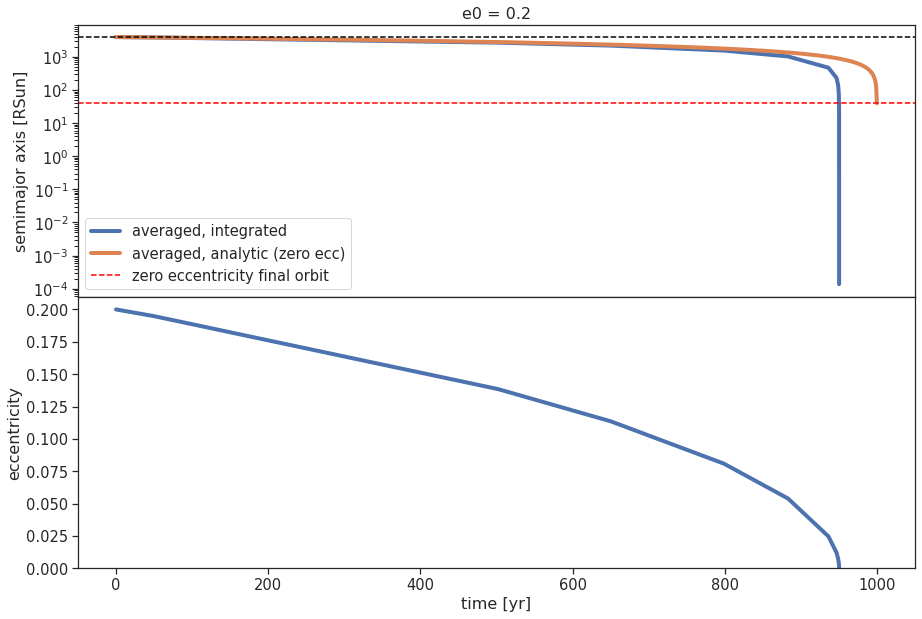

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(font_scale=1.33)
sns.set_style("ticks")

f, ax = plt.subplots(2, sharex=True, figsize=(15, 10))

ax[0].plot(t, a, lw=4, label="averaged, integrated")
ax[0].plot(tspan, analytic_a, lw=4, label="averaged, analytic (zero ecc)")

ax[0].set_ylabel("semimajor axis [RSun]")
ax[0].axhline(a0.value_in(units.RSun), c="black", ls="--")
ax[0].axhline(a1.value_in(units.RSun), c="red", ls="--", label="zero eccentricity final orbit")
ax[0].legend()
ax[0].set_title("e0 = {:g}".format(e0))

ax[0].set_yscale("log")
ax[1].plot(t, e, lw=4)
ax[1].set_ylabel("eccentricity")
ax[1].set_xlabel("time [yr]")
ax[1].set_ylim(bottom=0)

f.subplots_adjust(hspace=0)

plt.savefig("averaged_eccentric_integrated_vs_analytic.pdf")
plt.show()


<ipython-input-11-a376298f6656>:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_ylim(bottom=0)
<ipython-input-6-2a34e0060472>:29: RuntimeWarning: invalid value encountered in double_scalars
  da_dt = K / a * 2 * (1+e2) / (1 - e2)**1.5
<ipython-input-6-2a34e0060472>:35: RuntimeWarning: invalid value encountered in double_scalars
  de_dt = K / (a*a) * 2*e / (1 - e2)**0.5
<ipython-input-6-2a34e0060472>:29: RuntimeWarning: invalid value encountered in double_scalars
  da_dt = K / a * 2 * (1+e2) / (1 - e2)**1.5
<ipython-input-6-2a34e0060472>:35: RuntimeWarning: invalid value encountered in double_scalars
  de_dt = K / (a*a) * 2*e / (1 - e2)**0.5
<ipython-input-6-2a34e0060472>:29: RuntimeWarning: invalid value encountered in double_scalars
  da_dt = K / a * 2 * (1+e2) / (1 - e2)**1.5
<ipython-input-6-2a34e0060472>:35: RuntimeWarning: invalid value encountered in double_scalars
  de_dt = K / (a*a) * 2*e / (1 - e2)**0.

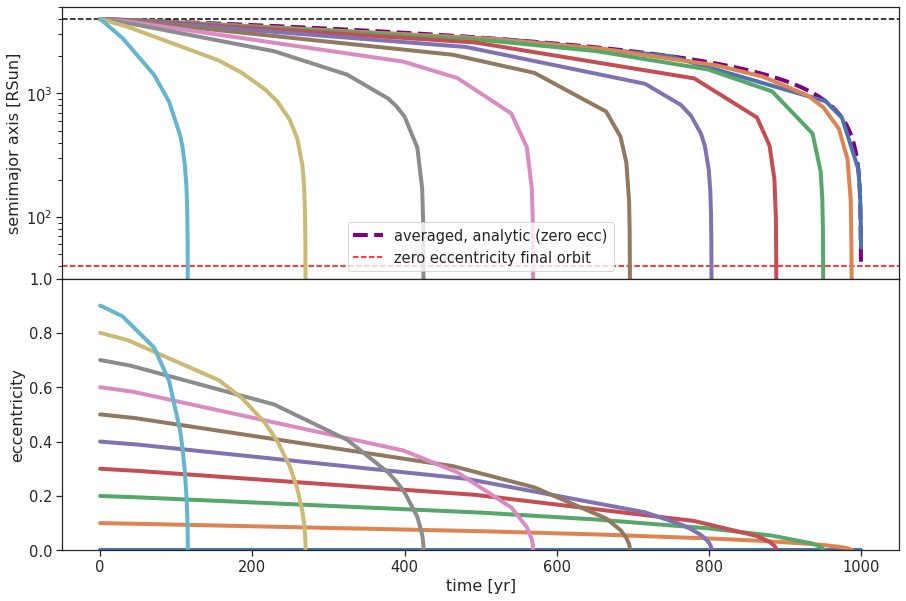

In [11]:
elist = np.arange(0.0, 1, 0.1)

tspan = np.linspace(0, 1000, 1000)
tspan = conv.to_nbody(tspan | units.yr).number
analytic_a = CE_model.CE_at_zeroe(tspan, a0_nb, CE_model.K)

f, ax = plt.subplots(2, sharex=True, figsize=(15, 10))
ax[0].plot(tspan, analytic_a, lw=4, label="averaged, analytic (zero ecc)", c="purple", ls="--")
ax[0].set_ylabel("semimajor axis [RSun]")
ax[0].axhline(a0.value_in(units.RSun), c="black", ls="--")
ax[0].axhline(a1.value_in(units.RSun), c="red", ls="--", label="zero eccentricity final orbit")
ax[0].legend()
ax[0].set_yscale("log")
ax[0].set_ylim(bottom=0)

ax[1].set_ylabel("eccentricity")
ax[1].set_xlabel("time [yr]")
ax[1].set_ylim(bottom=0)


for e0 in elist:
    CE_model = CE_drag_averaged(Eps0_nb, EpsCE_nb, TCE_nb, mu_nb)
    y0 = [a0_nb, e0]
    tfin = TCE_nb
    t, y = CE_model.evolve(y0, tfin, None)
    a, e = y
    
    ax[0].plot(t, a, lw=4, label="averaged, integrated e0={:g}".format(e0))
    ax[1].plot(t, e, lw=4)


f.subplots_adjust(hspace=0)

plt.savefig("averaged_eccentric_integrated_vs_analytic_multie.pdf")
plt.show()
